In [1]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [2]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c ml-marathon-final

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!ls

adc.json  data.zip  kaggle_dogcat  sample_data	sample_submission.csv


In [0]:
import zipfile

zip_ref = zipfile.ZipFile('data.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [7]:
!ls

adc.json  data.zip  kaggle_dogcat  sample_data	sample_submission.csv


#Preprocess Images

In [0]:
%matplotlib inline

import glob
import os
import re
import random

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image

In [0]:
def norm_image(img):
    """
    Normalize PIL image
    
    Normalizes luminance to (mean,std)=(0,1), and applies a [1%, 99%] contrast stretch
    """
    img_y, img_b, img_r = img.convert('YCbCr').split()
    
    img_y_np = np.asarray(img_y).astype(float)

    img_y_np /= 255
    img_y_np -= img_y_np.mean()
    img_y_np /= img_y_np.std()
    scale = np.max([np.abs(np.percentile(img_y_np, 1.0)),
                    np.abs(np.percentile(img_y_np, 99.0))])
    img_y_np = img_y_np / scale
    img_y_np = np.clip(img_y_np, -1.0, 1.0)
    img_y_np = (img_y_np + 1.0) / 2.0
    
    img_y_np = (img_y_np * 255 + 0.5).astype(np.uint8)

    img_y = Image.fromarray(img_y_np)

    img_ybr = Image.merge('YCbCr', (img_y, img_b, img_r))
    
    img_nrm = img_ybr.convert('RGB')
    
    return img_nrm

In [0]:
def resize_image(img, size):
    """
    Resize PIL image
    
    Resizes image to be square with sidelength size. Pads with black if needed.
    """
    # Resize
    n_x, n_y = img.size
    if n_y > n_x:
        n_y_new = size
        n_x_new = int(size * n_x / n_y + 0.5)
    else:
        n_x_new = size
        n_y_new = int(size * n_y / n_x + 0.5)

    img_res = img.resize((n_x_new, n_y_new), resample=PIL.Image.BICUBIC)

    # Pad the borders to create a square image
    img_pad = Image.new('RGB', (size, size), (128, 128, 128))
    ulc = ((size - n_x_new) // 2, (size - n_y_new) // 2)
    img_pad.paste(img_res, ulc)

    return img_pad

In [67]:
TRAIN_DIR = './kaggle_dogcat/train/'
TRAIN_DOGS_DIR = './kaggle_dogcat/train/dogs'
TRAIN_CATS_DIR = './kaggle_dogcat/train/cats'

TEST_DIR = './kaggle_dogcat/test/'


train_dogs =   [TRAIN_DIR+'dogs/'+i for i in os.listdir(TRAIN_DOGS_DIR)]
train_cats =   [TRAIN_DIR+'cats/'+i for i in os.listdir(TRAIN_CATS_DIR)]

test_all =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]

train_all = train_cats + train_dogs

random.shuffle(train_all)

print(test_all)

['./kaggle_dogcat/test/159.jpg', './kaggle_dogcat/test/277.jpg', './kaggle_dogcat/test/069.jpg', './kaggle_dogcat/test/365.jpg', './kaggle_dogcat/test/041.jpg', './kaggle_dogcat/test/250.jpg', './kaggle_dogcat/test/275.jpg', './kaggle_dogcat/test/172.jpg', './kaggle_dogcat/test/308.jpg', './kaggle_dogcat/test/134.jpg', './kaggle_dogcat/test/375.jpg', './kaggle_dogcat/test/267.jpg', './kaggle_dogcat/test/031.jpg', './kaggle_dogcat/test/353.jpg', './kaggle_dogcat/test/063.jpg', './kaggle_dogcat/test/266.jpg', './kaggle_dogcat/test/258.jpg', './kaggle_dogcat/test/073.jpg', './kaggle_dogcat/test/170.jpg', './kaggle_dogcat/test/316.jpg', './kaggle_dogcat/test/167.jpg', './kaggle_dogcat/test/348.jpg', './kaggle_dogcat/test/374.jpg', './kaggle_dogcat/test/301.jpg', './kaggle_dogcat/test/244.jpg', './kaggle_dogcat/test/162.jpg', './kaggle_dogcat/test/156.jpg', './kaggle_dogcat/test/064.jpg', './kaggle_dogcat/test/217.jpg', './kaggle_dogcat/test/116.jpg', './kaggle_dogcat/test/182.jpg', './kagg

660


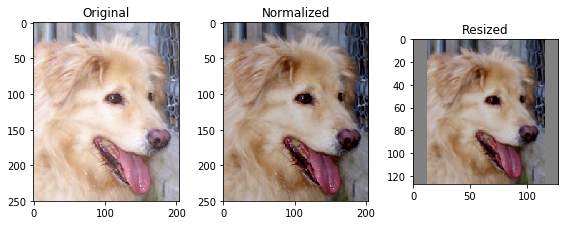

In [68]:
SIZE = 128  # for ImageNet models compatibility

# Read the image
choose_random_image = True
if choose_random_image:
    idx = np.random.randint(0, len(train_all))
else:
    idx = 24486
print(idx)
path = train_all[idx]
img = Image.open(path)

# Normalize it
img_nrm = norm_image(img)


# Resize it
img_res = resize_image(img_nrm, SIZE)

# Show it
plt.figure(figsize=(8,4))
plt.subplot(131)
plt.title('Original')
plt.imshow(img)

plt.subplot(132)
plt.title('Normalized')
plt.imshow(img_nrm)

plt.subplot(133)
plt.title('Resized')
plt.imshow(img_res)

plt.tight_layout()
plt.show()

In [0]:
ROWS = 128
COLS = 128
CHANNELS = 3

def read_image(file_path):
    # Normalize it
    img = Image.open(file_path)
    img_nrm = norm_image(img)

    # Resize it
    img_res = resize_image(img_nrm, ROWS)

    return img_res


def prep_data(images):
    count = len(images)
    data = np.ndarray((count,ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data
  


In [70]:
train = prep_data(train_all)
test = prep_data(test_all)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))

Processed 0 of 4000
Processed 1000 of 4000
Processed 2000 of 4000
Processed 3000 of 4000
Processed 0 of 400
Train shape: (4000, 128, 128, 3)
Test shape: (400, 128, 128, 3)


Text(0.5, 1.0, 'Cats and Dogs')

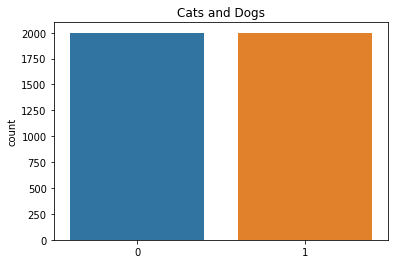

In [71]:
import seaborn as sns

labels = []
for i in train_all:
    if 'dogs' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
plt.title('Cats and Dogs')

In [0]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, RMSprop

In [0]:
def build_CNN(input_shape):
  

  model = Sequential()

  model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=input_shape, activation='relu'))
  model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
  model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
    
  model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
  model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
    
  model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
  model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
#   model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
# model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
# model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))
    
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(1))
  model.add(Activation('sigmoid'))

 

  return model
  
  


In [74]:
cnn_model = build_CNN(train.shape[1:])
#adam = keras.optimizers.Adam(lr = 0.001)
cnn_model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = RMSprop(lr=1e-4))
cnn_model.summary()



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(128, 128,..., activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Co

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 32, 32, 128)       73856     
__________

In [0]:
batch_size = 16
epochs = 50

In [76]:
history = cnn_model.fit(train, labels, batch_size=batch_size, nb_epoch=epochs,shuffle=True,
              validation_split=0.25)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 3000 samples, validate on 1000 samples
Epoch 1/50
3000/3000 [==============================] - 15s 5ms/step - loss: 0.7717 - acc: 0.5033 - val_loss: 0.6887 - val_acc: 0.5330
Epoch 2/50
3000/3000 [==============================] - 13s 4ms/step - loss: 0.6888 - acc: 0.5480 - val_loss: 0.6663 - val_acc: 0.6180
Epoch 3/50
3000/3000 [==============================] - 13s 4ms/step - loss: 0.6650 - acc: 0.6070 - val_loss: 0.6343 - val_acc: 0.6450
Epoch 4/50
3000/3000 [==============================] - 13s 4ms/step - loss: 0.6266 - acc: 0.6487 - val_loss: 0.6424 - val_acc: 0.6150
Epoch 5/50
3000/3000 [==============================] - 13s 4ms/step - loss: 0.5839 - acc: 0.7027 - val_loss: 0.6048 - val_acc: 0.6720
Epoch 6/50
3000/3000 [==============================] - 13s 4ms/step - loss: 0.5418 - acc: 0.7330 - val_loss: 0.5674 - val_acc: 0.7040
Epoch 7/50
3000/3000 [==============================] - 13s 4ms/step - loss: 0.5039 - acc: 0.7533 - val_loss: 0.5737 - val_acc: 0.7120
Epoch 8

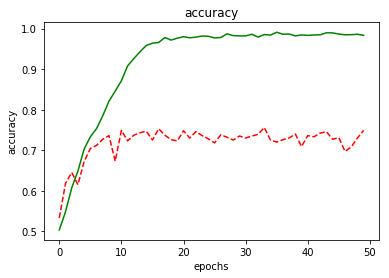

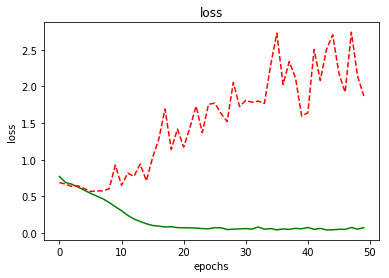

In [79]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], '-', label = 'train_acc', color = 'g')
plt.plot(history.history['val_acc'],'--', label = 'valid_acc', color = 'r')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

plt.plot(history.history['loss'], '-', label = 'train_loss', color = 'g')
plt.plot(history.history['val_loss'],'--', label = 'valid_loss', color = 'r')
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [0]:
predictions = cnn_model.predict(test, verbose=0)

I am 99.95% sure this is a Cat


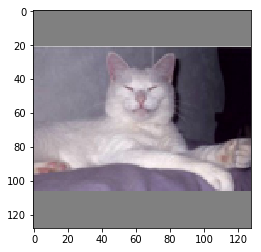

I am 96.84% sure this is a Cat


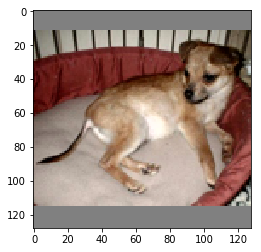

I am 100.00% sure this is a Cat


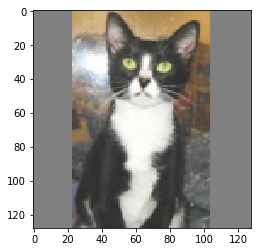

I am 100.00% sure this is a Dog


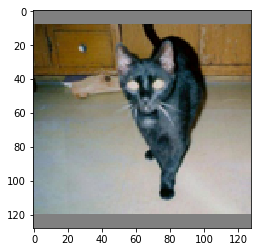

I am 99.94% sure this is a Cat


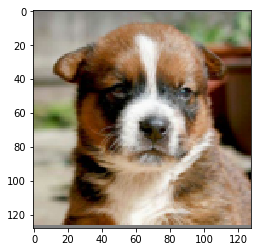

I am 100.00% sure this is a Dog


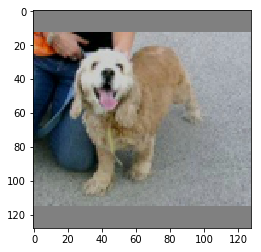

I am 99.99% sure this is a Cat


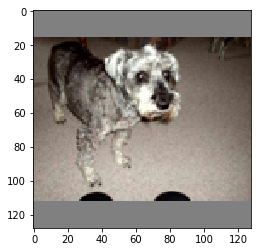

I am 100.00% sure this is a Cat


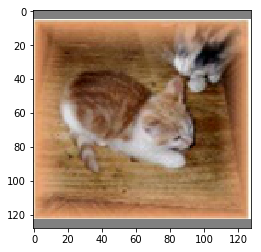

I am 86.83% sure this is a Dog


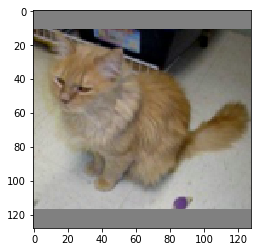

I am 99.40% sure this is a Cat


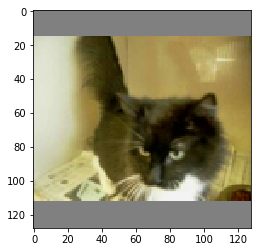

In [81]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i])
    plt.show()

In [0]:
predicted_val = [p[0] for p in predictions]

In [0]:
id_line = []

for p in os.listdir(TEST_DIR):
  id_line.append(p.split(".")[0])

In [95]:
test_all

['./kaggle_dogcat/test/159.jpg',
 './kaggle_dogcat/test/277.jpg',
 './kaggle_dogcat/test/069.jpg',
 './kaggle_dogcat/test/365.jpg',
 './kaggle_dogcat/test/041.jpg',
 './kaggle_dogcat/test/250.jpg',
 './kaggle_dogcat/test/275.jpg',
 './kaggle_dogcat/test/172.jpg',
 './kaggle_dogcat/test/308.jpg',
 './kaggle_dogcat/test/134.jpg',
 './kaggle_dogcat/test/375.jpg',
 './kaggle_dogcat/test/267.jpg',
 './kaggle_dogcat/test/031.jpg',
 './kaggle_dogcat/test/353.jpg',
 './kaggle_dogcat/test/063.jpg',
 './kaggle_dogcat/test/266.jpg',
 './kaggle_dogcat/test/258.jpg',
 './kaggle_dogcat/test/073.jpg',
 './kaggle_dogcat/test/170.jpg',
 './kaggle_dogcat/test/316.jpg',
 './kaggle_dogcat/test/167.jpg',
 './kaggle_dogcat/test/348.jpg',
 './kaggle_dogcat/test/374.jpg',
 './kaggle_dogcat/test/301.jpg',
 './kaggle_dogcat/test/244.jpg',
 './kaggle_dogcat/test/162.jpg',
 './kaggle_dogcat/test/156.jpg',
 './kaggle_dogcat/test/064.jpg',
 './kaggle_dogcat/test/217.jpg',
 './kaggle_dogcat/test/116.jpg',
 './kaggle

In [0]:
submission_df = pd.DataFrame({'ID':id_line, 'Predicted':predicted_val})

In [0]:
submission_df.to_csv("submission.csv", index=False)

In [0]:
from google.colab import files

files.download('submission.csv')